## MLE fit for two component binding - simulated and real data

In part one of this notebook we see how well we can reproduce Kd from simulated experimental data with a maximum likelihood function.

In part two of this notebook we see how well it can estimate the Kd from real experimental binding data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Part I

We use the same setup here as we do in the 'Simulating Experimental Fluorescence Binding Data' notebook.


Experimentally we won't know the Kd, but we know the Ptot and Ltot concentrations.


In [2]:
Kd = 2e-9 # M
Ptot = 1e-9 * np.ones([12],np.float64) # M
Ltot = 20.0e-6 / np.array([10**(float(i)/2.0) for i in range(12)]) # M


In [3]:
def two_component_binding(Kd, Ptot, Ltot):
    """
    Parameters
    ----------
    Kd : float
        Dissociation constant
    Ptot : float
        Total protein concentration
    Ltot : float
        Total ligand concentration
        
    Returns
    -------
    P : float
        Free protein concentration
    L : float
        Free ligand concentration
    PL : float
        Complex concentration
    """
                                    
    PL = 0.5 * ((Ptot + Ltot + Kd) - np.sqrt((Ptot + Ltot + Kd)**2 - 4*Ptot*Ltot))  # complex concentration (uM)
    P = Ptot - PL; # free protein concentration in sample cell after n injections (uM)                                                                                                                                                                                                                          
    L = Ltot - PL; # free ligand concentration in sample cell after n injections (uM)                                                                                                                                                                                                                           
    return [P, L, PL]

In [4]:
[L, P, PL] = two_component_binding(Kd, Ptot, Ltot)


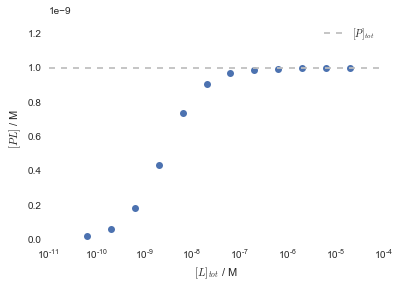

In [5]:
# y will be complex concentration
# x will be total ligand concentration
plt.semilogx(Ltot,PL, 'o')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$[PL]$ / M')
plt.ylim(0,1.3e-9)
plt.axhline(Ptot[0],color='0.75',linestyle='--',label='$[P]_{tot}$')
plt.legend();

## Now make this a fluorescence experiment.

In [6]:
# Making max 400 relative fluorescence units, and scaling all of PL to that
npoints = len(Ltot)
sigma = 10.0 # size of noise
F_i = (400/1e-9)*PL + sigma * np.random.randn(npoints)
#Pstated = np.ones([npoints],np.float64)*Ptot
#Lstated = Ltot

/Users/hansons/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


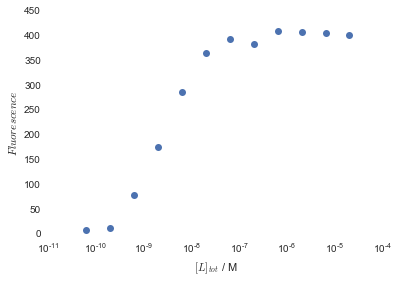

In [7]:
# y will be complex concentration
# x will be total ligand concentration
plt.semilogx(Ltot,F_i, 'o')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend();

In [8]:
#And makeup an F_L
F_L = 0.3

In [9]:
F_i

array([ 402.16126549,  407.00935545,  409.4424629 ,  410.63713133,
        385.29730155,  393.71934784,  366.14748583,  287.22825923,
        176.2715694 ,   80.58852261,   13.47768747,   10.0711431 ])

In [10]:
def find_Kd_from_fluorescence(params):
    
    [F_background, F_PL, Kd] = params
    
    N = len(Ltot)
    Fmodel_i = np.zeros([N])
    
    for i in range(N):
        [P, L, PL] = two_component_binding(Kd, Ptot[0], Ltot[i])
        Fmodel_i[i] = (F_PL*PL + F_L*L) + F_background
    
    return Fmodel_i

In [11]:
400/1E-9

400000000000.0

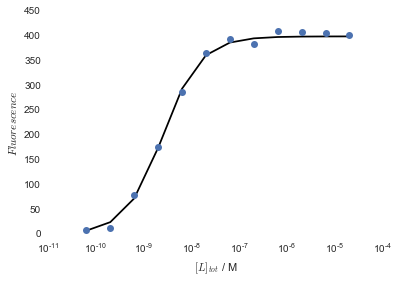

In [12]:

initial_guess = [0,400/1e-9,2e-9]
prediction = find_Kd_from_fluorescence(initial_guess)

plt.semilogx(Ltot,prediction,color='k')
plt.semilogx(Ltot,F_i, 'o')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend();

In [13]:
def sumofsquares(params):
    prediction = find_Kd_from_fluorescence(params)
    return np.sum((prediction - F_i)**2)

In [14]:
initial_guess = [0,3E11,1E-9]
fit = optimize.minimize(sumofsquares,initial_guess,method='Nelder-Mead')
print "The predicted parameters are", fit.x

The predicted parameters are [ -8.91696274e-01   4.05263953e+11   2.08557840e-09]


In [15]:
fit_prediction = find_Kd_from_fluorescence(fit.x)

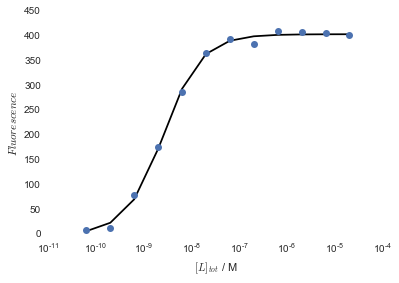

In [16]:
plt.semilogx(Ltot,fit_prediction,color='k')
plt.semilogx(Ltot,F_i, 'o')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend();

In [17]:
Kd_MLE = fit.x[2]

In [18]:
if (Kd_MLE < 1e-12):
    Kd_summary = "Kd = %.1f nM " % (Kd_MLE/1e-15)
elif (Kd_MLE < 1e-9):
    Kd_summary = "Kd = %.1f pM " % (Kd_MLE/1e-12)
elif (Kd_MLE < 1e-6):
    Kd_summary = "Kd = %.1f nM " % (Kd_MLE/1e-9)
elif (Kd_MLE < 1e-3):
    Kd_summary = "Kd = %.1f uM " % (Kd_MLE/1e-66)
elif (Kd_MLE < 1):
    Kd_summary = "Kd = %.1f mM " % (Kd_MLE/1e-3)
else:
    Kd_summary = "Kd = %.3e M " % (Kd_MLE)

In [19]:
delG_summary = "delG = %s kT" %np.log(Kd_MLE)

In [20]:
Kd_summary

'Kd = 2.1 nM '

In [21]:
delG_summary 

'delG = -19.9882196118 kT'

## Part II

Now we will see how well this does for real data.

In [22]:
# This requires that we import a few new libraries
from assaytools import platereader
import string


Couldn't import dot_parser, loading of dot files will not be possible.


In [23]:
Ptot = 0.5e-6 * np.ones([24],np.float64) # protein concentration, M
Ltot = np.array([20.0e-6,14.0e-6,9.82e-6,6.88e-6,4.82e-6,3.38e-6,2.37e-6,1.66e-6,1.16e-6,0.815e-6,0.571e-6,0.4e-6,0.28e-6,0.196e-6,0.138e-6,0.0964e-6,0.0676e-6,0.0474e-6,0.0320e-6,0.0240e-6,0.0160e-6,0.0120e-6,0.008e-6,0.00001e-6], np.float64) # ligand concentration, M

In [24]:
singlet_file = './data/p38_singlet1_20160420_153238.xml'

In [25]:
data = platereader.read_icontrol_xml(singlet_file)

In [26]:
#I want the Bosutinib-p38 data from rows I (protein) and J (buffer).
data_protein = platereader.select_data(data, '280_480_TOP_120', 'I')
data_buffer = platereader.select_data(data, '280_480_TOP_120', 'J')

In [27]:
data_protein

{'I1': '16546',
 'I10': '8280',
 'I11': '7005',
 'I12': '5827',
 'I13': '4967',
 'I14': '4378',
 'I15': '3859',
 'I16': '3513',
 'I17': '3176',
 'I18': '3001',
 'I19': '2855',
 'I2': '16009',
 'I20': '2736',
 'I21': '2647',
 'I22': '2552',
 'I23': '2515',
 'I24': '2487',
 'I3': '15707',
 'I4': '14688',
 'I5': '14146',
 'I6': '12881',
 'I7': '12583',
 'I8': '11251',
 'I9': '10015'}

In [28]:
#Sadly we also need to reorder our data and put it into an array to make the analysis easier
#This whole thing should be moved to assaytools.platereader hopefully before too many other people see this.

well = dict()
for j in string.ascii_uppercase:
    for i in range(1,25):
        well['%s' %j + '%s' %i] = i

def reorder2list(data,well):
    
    sorted_keys = sorted(well.keys(), key=lambda k:well[k])
    
    reorder_data = []
    
    for key in sorted_keys:
        try:
            reorder_data.append(data[key])
        except:
            pass

    reorder_data = [r.replace('OVER','70000') for r in reorder_data]
        
    reorder_data = np.asarray(reorder_data,np.float64)
    
    return reorder_data

reorder_protein = reorder2list(data_protein,well)
reorder_buffer = reorder2list(data_buffer,well)

In [29]:
reorder_protein

array([ 16546.,  16009.,  15707.,  14688.,  14146.,  12881.,  12583.,
        11251.,  10015.,   8280.,   7005.,   5827.,   4967.,   4378.,
         3859.,   3513.,   3176.,   3001.,   2855.,   2736.,   2647.,
         2552.,   2515.,   2487.])

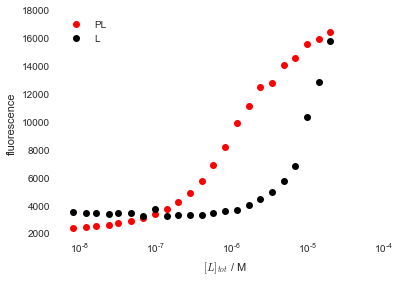

In [30]:
plt.semilogx(Ltot,reorder_protein, 'ro', label='PL')
plt.semilogx(Ltot,reorder_buffer, 'ko', label='L')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('fluorescence')
plt.xlim(5e-9,1.3e-4)
plt.legend(loc=2);

In [31]:
# for this to work we need to provide some initial values
# some of these we already have
F_i = reorder_protein

#And makeup an F_L
F_L = 0.3

# initial guess for [F_background, F_PL, Kd]
initial_guess = [0,400/1e-9,2e-9]

In [32]:
F_i

array([ 16546.,  16009.,  15707.,  14688.,  14146.,  12881.,  12583.,
        11251.,  10015.,   8280.,   7005.,   5827.,   4967.,   4378.,
         3859.,   3513.,   3176.,   3001.,   2855.,   2736.,   2647.,
         2552.,   2515.,   2487.])

In [33]:
fit = optimize.minimize(sumofsquares,initial_guess,method='Nelder-Mead')
print "The predicted parameters [F_background, F_PL, Kd] are ", fit.x

The predicted parameters [F_background, F_PL, Kd] are  [  2.46679644e+03   2.86639020e+10   9.07519322e-07]


In [34]:
fit.x[0]

2466.7964398297158

In [35]:
fit_prediction = find_Kd_from_fluorescence(fit.x)

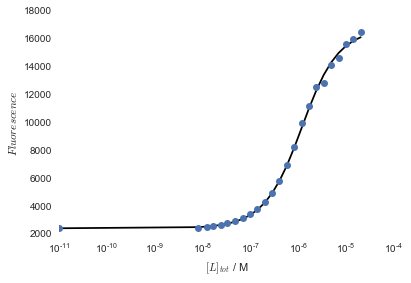

In [36]:
plt.semilogx(Ltot,fit_prediction,color='k')
plt.semilogx(Ltot,reorder_protein, 'o')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend();

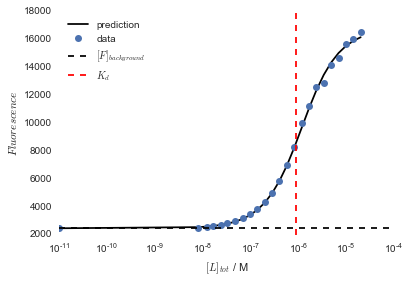

In [37]:
plt.semilogx(Ltot,fit_prediction,color='k', label='prediction')
plt.semilogx(Ltot,reorder_protein, 'o', label='data')
plt.axhline(fit.x[0],color='k',linestyle='--', label='$[F]_{background}$')
plt.axvline(fit.x[2],color='r',linestyle='--', label='$K_d$')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend(loc=2);

In [38]:
Kd_summary

'Kd = 2.1 nM '

In [39]:
delG_summary 

'delG = -19.9882196118 kT'